In [1]:
import sys
import sklearn
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt


In [2]:
def get_data():
    return pd.read_csv('metadata.csv/metadata.csv')

meta = get_data()


In [3]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])


In [4]:
y = dict()
y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

# Visualization code using plotly or matplotlib
# (Visualization code not shown for brevity)


In [6]:
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('faces_224/'+img[:-4]+'.jpg'))
        labels.append(1 if imclass == 'FAKE' else 0)
    return np.array(images), np.array(labels)

X_train, y_train = retrieve_dataset(Train_set)


In [7]:
X_val, y_val = retrieve_dataset(Val_set)


In [8]:
X_test, y_test = retrieve_dataset(Test_set)


In [9]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

In [10]:
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/5
560/560 [==============================] - 79s 118ms/step - loss: 28.0643 - accuracy: 0.5028 - val_loss: 0.6924 - val_accuracy: 0.4924
Epoch 2/5
560/560 [==============================] - 64s 114ms/step - loss: 0.8660 - accuracy: 0.5087 - val_loss: 0.6936 - val_accuracy: 0.5120
Epoch 3/5
560/560 [==============================] - 65s 116ms/step - loss: 15.1853 - accuracy: 0.5030 - val_loss: 0.6952 - val_accuracy: 0.5125
Epoch 4/5
560/560 [==============================] - 66s 118ms/step - loss: 0.7344 - accuracy: 0.5302 - val_loss: 0.6855 - val_accuracy: 0.5562
Epoch 5/5
560/560 [==============================] - 61s 109ms/step - loss: 0.6822 - accuracy: 0.5621 - val_loss: 0.6821 - val_accuracy: 0.5573


In [11]:
score = model.evaluate(X_test, y_test)


100/100 [==============================] - 5s 39ms/step - loss: 0.6813 - accuracy: 0.5572


In [12]:
base_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_val, y_val))

score = model.evaluate(X_test, y_test)


51877672/51877672 [==============================] - 5s 0us/step


c:\Users\mahes\anaconda3\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/5
560/560 [==============================] - 76s 116ms/step - loss: 0.8566 - accuracy: 0.5167 - val_loss: 0.6895 - val_accuracy: 0.5362
Epoch 2/5
560/560 [==============================] - 62s 111ms/step - loss: 0.6922 - accuracy: 0.5195 - val_loss: 0.6914 - val_accuracy: 0.5151
Epoch 3/5
560/560 [==============================] - 61s 110ms/step - loss: 0.6922 - accuracy: 0.5194 - val_loss: 0.6843 - val_accuracy: 0.5466
Epoch 4/5
560/560 [==============================] - 62s 110ms/step - loss: 0.6921 - accuracy: 0.5093 - val_loss: 0.6890 - val_accuracy: 0.5120
Epoch 5/5
100/100 [==============================] - 16s 132ms/step - loss: 0.6875 - accuracy: 0.5525


100/100 [==============================] - 15s 128ms/step


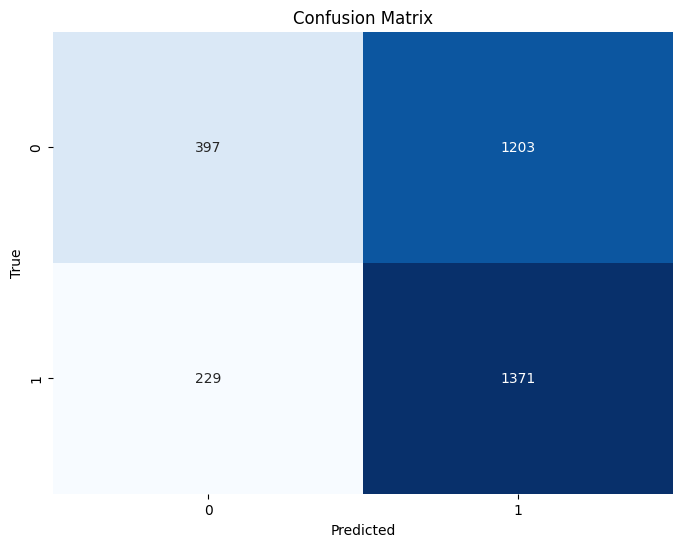

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have already evaluated the model and obtained predictions
predictions = model.predict(X_test)
y_pred = (predictions > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
